In [1]:
from comet_ml import Experiment, Optimizer

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import seaborn as sns
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

In [3]:
import node

In [4]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

In [5]:
from tabular_hypernet import Hypernetwork
from tabular_hypernet.modules import SimpleNetwork
from tabular_hypernet.training_utils import train_slow_step, train_model
from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface

In [6]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [7]:
DEVICE = 'cuda:1'

## Load data

In [8]:
data = pd.read_csv("../data/Blastchar/churn.csv")

In [9]:
def show_fractions(arr):
    for cls_ in sorted(pd.unique(arr)):
        print(f"{cls_} samples: {(arr==cls_).sum()} ({(arr==cls_).sum()/len(arr)*100:.1f}%)")

processed_data = data.copy()
del processed_data["customerID"]

y_label_enc = LabelEncoder()
y = y_label_enc.fit_transform(processed_data["Churn"].values)
del processed_data["Churn"]

show_fractions(y)

0 samples: 5174 (73.5%)
1 samples: 1869 (26.5%)


In [10]:
label_encoders = {}

for col in processed_data.columns:
    if processed_data[col].dtype == 'object':
        encoder = LabelEncoder()
        processed_data[col] = encoder.fit_transform(processed_data[col].values)
        label_encoders[col] = encoder
        
X = processed_data.values
print(X.shape)

(7043, 19)


### Split it into train and test set

In [11]:
class GenericDataset(torch.utils.data.IterableDataset):
    def __init__(self, data, shuffle: bool=False, samples_no: int=None):
        samples = samples_no or len(data[0])
        self.indices = np.arange(samples)
        self.shuffle = True
        if shuffle:
            self.indices = np.random.permutation(self.indices)
        self.index = 0
        self.max_samples = samples
        self.data_x = data[0].to(torch.float32)
        self.data_y = data[1]

    def __iter__(self):
        if self.shuffle:
            self.indices = np.random.permutation(self.indices)
        while self.index < self.max_samples:
            _idx = self.indices[self.index]
            yield self.data_x[_idx], self.data_y[_idx]
            self.index += 1
    
    def __len__(self):
        return self.data_x.shape[0]

class OversamplingDataset(GenericDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        fractions = {i: (self.data_y==i).sum()/len(self.data_y) for i in self.data_y.unique()}
        print(fractions)
        

def get_dataloader(X, y, size=None, batch_size=32):
    train_dataset = GenericDataset((X, y))
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1)
    
    return trainloader

In [12]:
import imblearn

In [13]:
# np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000)

X_train, y_train = imblearn.over_sampling.RandomOverSampler().fit_resample(X_train, y_train)


print("Training data:")
show_fractions(y_train)

print("Test data:")
show_fractions(y_test)

Training data:
0 samples: 723 (50.0%)
1 samples: 723 (50.0%)
Test data:
0 samples: 4451 (73.7%)
1 samples: 1592 (26.3%)


## Preprocess

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]

## Benchmark

In [16]:
criterion = torch.nn.CrossEntropyLoss()

def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    results.append({
        "Class": "F1 score",
        "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    results.append({
        "Class": "ROC score",
        "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
    })
    results.append({
        "Class": "Precision",
        "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    results.append({
        "Class": "Recall",
        "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    results.append({
        "Class": "Loss",
        "Metric": criterion(torch.from_numpy(y_score), y_test).item()*100
    })
    return results


def test_model(model_fn, train_data, test_data, label_encoder=None, iters=10):
    X_train, y_train = train_data
    X_test, y_test = test_data
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(test_data))
    
    results = []

    for i in range(iters):
        model = model_fn()

        model.fit(X_train, y_train);    
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

def print_statistics(dframe):
    mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
    print(f"F1: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
    print(f"C-statistics: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="Precision"].mean(), dframe[dframe["Class"]=="Precision"].std()
    print(f"Precision: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="Recall"].mean(), dframe[dframe["Class"]=="Recall"].std()
    print(f"Recall: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")
    
def log_statistics(dframe):
    mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
    logger.info(f"F1: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
    logger.info(f"C-statistics: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="Precision"].mean(), dframe[dframe["Class"]=="Precision"].std()
    logger.info(f"Precision: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="Recall"].mean(), dframe[dframe["Class"]=="Recall"].std()
    logger.info(f"Recall: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

### XGBoost

In [17]:
from xgboost import XGBClassifier

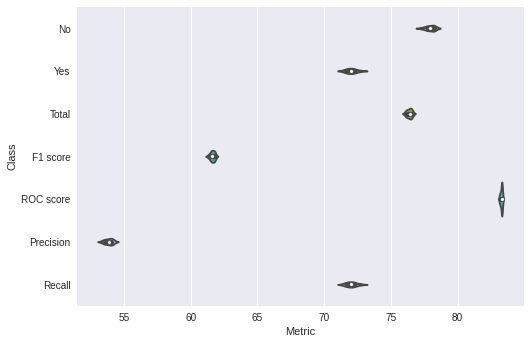

In [18]:
def get_xgboost():
    random_seed = np.random.randint(1024)
    return XGBClassifier(
        verbosity=0,
        random_state=random_seed,
        subsample=0.98,
        use_label_encoder=False)

xgb_dframe = test_model(get_xgboost, 
                        (X_train, y_train), 
                        (X_test, y_test),
                        label_encoder=y_label_enc, iters=10)

In [73]:
print_statistics(xgb_dframe)

F1: 60.509 ~ 0.284
C-statistics: 82.926 ~ 0.121
Precision: 51.717 ~ 0.295
Recall: 72.906 ~ 0.443


/tmp/ipykernel_627365/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_627365/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_627365/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]

### Neural network

In [19]:
def simple_network_fn(epochs):
    def _inner():
#         net = SimpleNetwork(X_train.shape[1], outputs=2).to(DEVICE)
        net = torch.nn.Sequential(
            torch.nn.Dropout(1-15/19),
            torch.nn.Linear(X_train.shape[1], 100),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(100, 2)
        ).to(DEVICE)
        return SimpleSklearnInterface(net, device=DEVICE, epochs=epochs, batch_size=32)
    return _inner

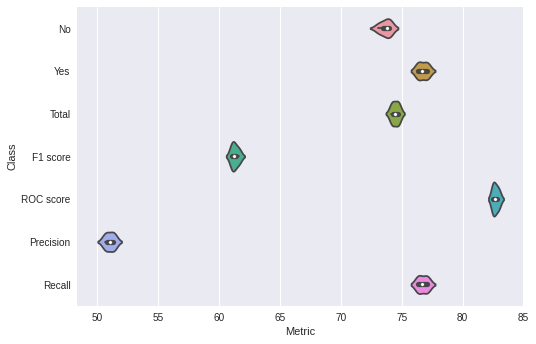

In [20]:
simple_nn_results = test_model(simple_network_fn(150),
                (X_train, y_train), 
                (X_test, y_test),
                y_label_enc, 4)

In [21]:
print_statistics(simple_nn_results)

F1: 61.294 ~ 0.285
C-statistics: 82.697 ~ 0.240
Precision: 51.031 ~ 0.378
Recall: 76.727 ~ 0.402


/tmp/ipykernel_912531/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_912531/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_912531/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]

### NODE

In [30]:
from qhoptim.pyt import QHAdam

In [31]:
def node_fn(layer_dims):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_train.shape[1], layer_dims, num_layers=1, tree_dim=2, depth=6, flatten_output=False,
                           choice_function=node.entmax15, bin_function=node.entmoid15),
            node.Lambda(lambda x: x.mean(dim=1))
        )
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_train[:1000], device='cpu').to(torch.float32))
        
        network = network.to(DEVICE)
        network.device=DEVICE
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=150, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/node/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."
/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/qhoptim/pyt/qhadam.py:133: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1_adj).add_(1.0 - beta1_adj, d_p)
/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-p

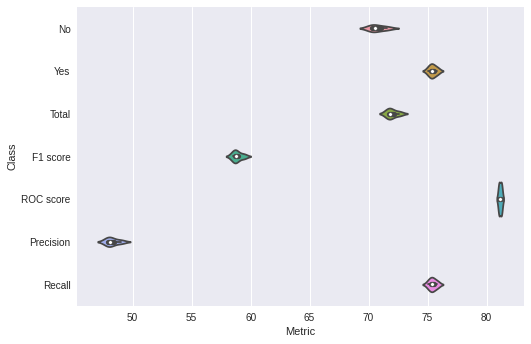

In [32]:
node_results = test_model(node_fn(128),
                (X_train, y_train), 
                (X_test, y_test),
                y_label_enc, 4)

In [33]:
print_statistics(node_results)

F1: 58.855 ~ 0.387
C-statistics: 81.151 ~ 0.116
Precision: 48.258 ~ 0.522
Recall: 75.420 ~ 0.314


/tmp/ipykernel_627365/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_627365/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_627365/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]

In [34]:
X_train.shape

torch.Size([152, 19])

### Hypernetwork

In [22]:
def network_fn(epochs):
    def _inner():
        network = Hypernetwork(inp_size=X_train.shape[1], 
                            out_size=y.max().item()+1, 
                            mask_size=15,
                            layers=[128, 128, 128],
                            node_hidden_size=100, 
                            test_nodes=15, device=DEVICE).to(DEVICE)

        network = HypernetworkSklearnInterface(network, device=DEVICE, epochs=epochs, batch_size=32)
        return network
    return _inner

In [23]:
# # torch.manual_seed(42)
# # np.random.seed(42)

# hypernet = network_fn(2)()
# hypernet.network.to("cpu")
# res = hypernet.network(X_train[:1].float(), hypernet.network.test_mask[:1].to("cpu").float()).detach().numpy()


# # assert np.isclose(res[0][0], -0.1093888) and np.isclose(res[0][1], -0.14375031), res[0]

AssertionError: [0.19917154 0.024545  ]

In [24]:
def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:43<00:00,  3.47it/s]


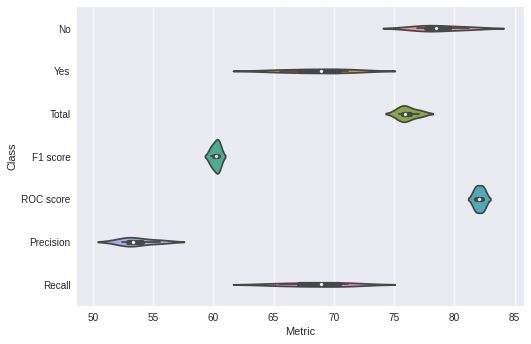

In [25]:
nn_results = test_model(network_fn(150),
                (X_train, y_train), 
                (X_test, y_test),
                y_label_enc, 4)

In [25]:
res = {}
for epochs in [100]:
    nn_results = test_model(network_fn(epochs),
                    (X_train, y_train), 
                    (X_test, y_test),
                    y_label_enc, 4)
    exp = Experiment(os.environ.get("COMET_KEY"), "blastchar-hypernet")
    exp.log_parameters({"epochs": epochs})
    exp.add_tag("hypernet-epoch-optim")
    exp.log_table("metrics.csv", nn_results.groupby("Class").mean())
    exp.log_metric("f1_score", nn_results.groupby("Class").mean().loc["F1 score"])
    
    res[epochs] = nn_results
    logger.info(f"Number of epochs: {epochs}")
    print_statistics(res[epochs])
    

 20%|██████████████████████████████████████▌                                                                                                                                                          | 1/5 [00:00<00:00,  5.90it/s]


KeyboardInterrupt: 

In [26]:
print_statistics(nn_results)

F1: 60.194 ~ 0.317
C-statistics: 82.064 ~ 0.352
Precision: 53.665 ~ 1.332
Recall: 68.640 ~ 2.559


/tmp/ipykernel_912531/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_912531/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_912531/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]

#### Hyperparameter optimizations

In [27]:
from tabular_hypernet.training_utils import train_slow_step
hypernet_res = []
for batch_size in [4, 8, 16, 32, 64]:
    start = time.time()

    exp = Experiment(os.environ.get("COMET_KEY"), "blastchar-hypernet")
    exp.log_parameters({"batch_size": batch_size})
    # nn_results = test_model(network_fn(batch_size),
    #                         (X_train, y_train), 
    #                         (X_test, y_test), 
    #                         y_label_enc, 1)

    hypernet = network_fn(batch_size)()
    train_slow_step(hypernet.network,
                    hypernet.optimizer,
                    hypernet.criterion,
                    (get_dataloader(X_train, y_train, batch_size=batch_size),
                     get_dataloader(X_test, y_test, batch_size=64)),
                    X_train.shape[0],
                    1500,
                    15,
                    exp, device=DEVICE, test_every=50)
                    
                    
    nn_results["Batch size"] = batch_size
    plt.title(f"Batch size: {batch_size}")

    loss = nn_results[nn_results["Class"]=="Loss"]["Accuracy"]
    accuracy = nn_results[nn_results["Class"]=="Total"]["Accuracy"]
    exp.log_metric("mean_loss", loss.mean())
    exp.log_metric("loss_std", loss.std())
    exp.log_metric("mean_acc", accuracy.mean())
    exp.log_metric("acc_std", accuracy.std())

    exp.log_dataframe_profile(nn_results)
    exp.log_html(figure_to_html())
    plt.show()

    hypernet_res.append(nn_results)

    end = datetime.timedelta(seconds=time.time()-start)
    logger.info(f"{batch_size=} done in {str(end)}. Loss: {loss.mean():.3g}+-{loss.std():.3g}. Acc: {accuracy.mean():.1f}+-{accuracy.std():.2f}")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/blastchar-hypernet/603fe5d1bb1941e28f04da6158ba3d89
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [251]         : (0.003964078612625599, 1.5225090980529785)
COMET INFO:     test_accuracy [13] : (65.86489989917904, 72.76393489845888)
COMET INFO:     test_loss [13]     : (0.008956598734179165, 0.010721816477301003)
COMET INFO:   Parameters:
COMET INFO:     batch_size              : 4
COMET INFO:     check_val_every_n_epoch : 5
COMET INFO:     lr                      : 0.0003
COMET INFO:     mask_size               : 15
COMET INFO:     masks_no                : 15
COMET INFO:     max_epochs              : 1500
COMET INFO:     node_hidden_size        : 100
COMET INFO:     test_nodes              : 15
COMET INFO:     trainin

KeyboardInterrupt: 

### TabNet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [149]:
np.array(X_train).shape

(134, 19)

Device used : cuda
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.84536 |  0:00:00s
epoch 1  | loss: 0.70384 |  0:00:00s
epoch 2  | loss: 0.62857 |  0:00:00s
epoch 3  | loss: 0.5942  |  0:00:00s
epoch 4  | loss: 0.59312 |  0:00:00s
epoch 5  | loss: 0.54083 |  0:00:00s
epoch 6  | loss: 0.52085 |  0:00:00s
epoch 7  | loss: 0.50849 |  0:00:00s
epoch 8  | loss: 0.50789 |  0:00:00s
epoch 9  | loss: 0.47963 |  0:00:00s
epoch 10 | loss: 0.4389  |  0:00:00s
epoch 11 | loss: 0.43232 |  0:00:00s
epoch 12 | loss: 0.40346 |  0:00:00s
epoch 13 | loss: 0.3868  |  0:00:00s
epoch 14 | loss: 0.40405 |  0:00:00s
epoch 15 | loss: 0.39284 |  0:00:00s
epoch 16 | loss: 0.39727 |  0:00:00s
epoch 17 | loss: 0.36165 |  0:00:00s
epoch 18 | loss: 0.38959 |  0:00:00s
epoch 19 | loss: 0.40563 |  0:00:00s
epoch 20 | loss: 0.40416 |  0:00:00s
epoch 21 | loss: 0.31999 |  0:00:00s
epoch 22 | loss: 0.3385  |  0:00:00s
epoch 23 | loss: 0.32313 |  0:00:00s
epoch 24 | loss: 0.3

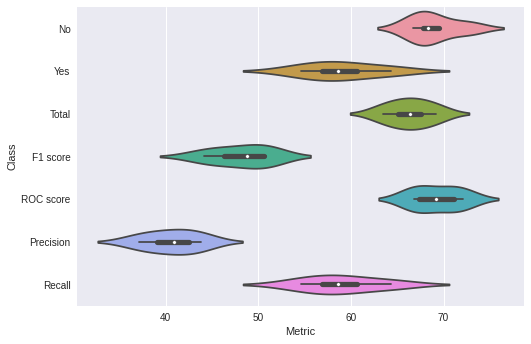

In [150]:
def tabnet_fn():
    clf = TabNetClassifier(seed=np.random.randint(1024))
    return clf

tabnet_results = test_model(tabnet_fn,
                    (np.array(X_train), np.array(y_train)), 
                    (X_test, y_test),
                    y_label_enc, 4)

In [151]:
print_statistics(tabnet_results)

F1: 48.135 ~ 3.153
C-statistics: 69.298 ~ 2.537
Precision: 40.670 ~ 2.924
Recall: 59.028 ~ 4.102


/tmp/ipykernel_276146/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_276146/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_276146/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]